# Imports

In [39]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from skimage.morphology import binary_dilation, binary_erosion, dilation, erosion

# Load Data

## MNIST

In [40]:
ds_mnist = tfds.load('mnist', split='train')
df_mnist = tfds.as_dataframe(ds_mnist)
print(f'{df_mnist.shape=}')
print(f"Image shape: {df_mnist['image'][0].shape}")

df_mnist.shape=(60000, 2)
Image shape: (28, 28, 1)


## Fashion MNIST

In [41]:
ds_fmnist = tfds.load('fashion_mnist', split='train')
df_fmnist = tfds.as_dataframe(ds_fmnist)
print(f'{df_fmnist.shape=}')
print(f"Image shape: {df_fmnist['image'][0].shape}")

df_fmnist.shape=(60000, 2)
Image shape: (28, 28, 1)


## EMNIST

In [42]:
# Takes about 15 mins
ds_emnist = tfds.load('emnist', split='train')
df_emnist = tfds.as_dataframe(ds_emnist)
print(f'{df_emnist.shape=}')
print(f"Image shape: {df_emnist['image'][0].shape}")

df_emnist.shape=(697932, 2)
Image shape: (28, 28, 1)


# Explore images

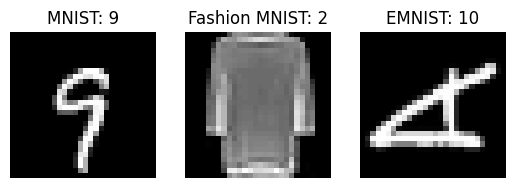

In [43]:
fig, axs = plt.subplots(ncols=3, nrows=1)

mnist = df_mnist['image'][100].squeeze()
mnist_title = df_mnist['label'][100]

fmnist = df_fmnist['image'][100].squeeze()
fmnist_title = df_fmnist['label'][100]

# The images are inverted horizontally and rotated 90 anti-clockwise
emnist = df_emnist['image'][100].squeeze()
emnist_title = df_emnist['label'][100]

axs[0].set_title(f'MNIST: {mnist_title}')
axs[0].axis('off')
axs[0].imshow(mnist, cmap='gray')

axs[1].set_title(f'Fashion MNIST: {fmnist_title}')
axs[1].axis('off')
axs[1].imshow(fmnist, cmap='gray')

axs[2].set_title(f'EMNIST: {emnist_title}')
axs[2].axis('off')
axs[2].imshow(emnist, cmap='gray')

plt.show();

# Remove labels

In [76]:
# For some reason the data type of the images is object.
df_mnist['image']

0        [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...
1        [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...
2        [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...
3        [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...
4        [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...
                               ...                        
59995    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...
59996    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...
59997    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...
59998    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...
59999    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...
Name: image, Length: 60000, dtype: object

In [45]:
dfs = [df_mnist, df_fmnist, df_emnist]
arrs = []

for i in range(len(dfs)):
    arrs.append(
        np.array(
            dfs[i]['image'].tolist(),
            dtype='uint8'
        ).squeeze()
    )

arrs[0].shape

(60000, 28, 28)

# Binarize

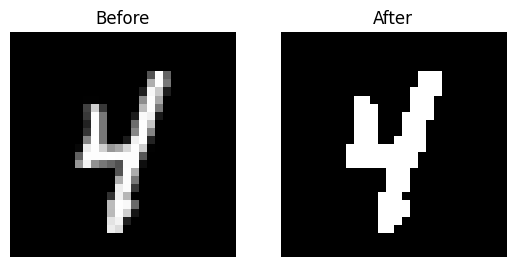

In [46]:
fig, axs = plt.subplots(ncols=2, nrows=1)

before = arrs[0][0]
after = np.where(arrs[0] > 0, 1, 0)[0]

axs[0].set_title('Before')
axs[0].axis('off')
axs[0].imshow(before, cmap='gray')

axs[1].set_title('After')
axs[1].axis('off')
axs[1].imshow(after, cmap='gray')

plt.show();

In [47]:
for i in range(len(arrs)):
    arrs[i] = np.where(arrs[i] > 0, 1, 0)

# Pattern matching :) !
arr_mnist, arr_fmnist, arr_emnist = arrs

# See results

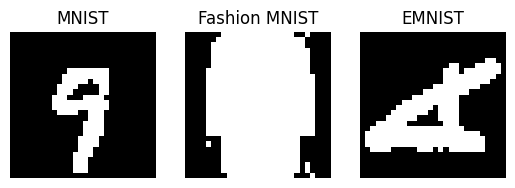

In [48]:
mnist = arr_mnist[100]
fmnist = arr_fmnist[100]
emnist = arr_emnist[100]

fig, axs = plt.subplots(ncols=3, nrows=1)

axs[0].set_title('MNIST')
axs[0].axis('off')
axs[0].imshow(mnist, cmap='gray')

axs[1].set_title('Fashion MNIST')
axs[1].axis('off')
axs[1].imshow(fmnist, cmap='gray')

axs[2].set_title('EMNIST')
axs[2].axis('off')
axs[2].imshow(emnist, cmap='gray')

plt.show();

# Sample from arrays

In [49]:
def print_batch(batch, title='Batch'):
    plt.figure(figsize=(15, 20))
    plt.title(title)
    plt.axis('off')
    
    if len(batch.shape) > 2:
        batch = np.hstack(batch)
    
    plt.imshow(batch, cmap='gray')


def get_batch_pics(num=10, seed=None):
    result = np.zeros((num, *arr_mnist.shape[1:]))

    np.random.seed(seed)
    arr_idxs = np.random.choice([0, 1, 2], size=num)
    pic_idxs = np.random.choice(range(df_mnist.shape[0]), size=num)

    for (i, (arr_idx, pic_idx)) in enumerate(zip(arr_idxs, pic_idxs)):
        result[i] = arrs[arr_idx][pic_idx]

    return result

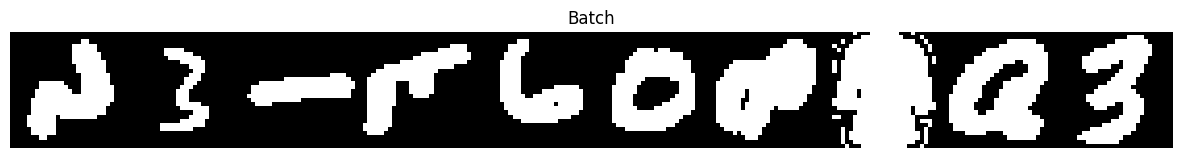

In [50]:
batch = get_batch_pics(seed=42)
print_batch(batch)

# Dilation

In [51]:
def dilate_binary(im, footprint):
    # Sadly, Python does not allow for a readable use of higher-order functions
    # list(map(lambda tup: (tup[0] // 28, tup[0] % 28), filter(lambda tup: tup[1] == 1, enumerate(batch[1].flatten()))))

    if footprint.shape[0] != footprint.shape[1] or footprint[footprint.shape[0] // 2, footprint.shape[1] // 2] != 1:
        raise ValueError('Footprint must be a square with 1 in its center!')

    im = im.astype(np.uint8)

    result = np.zeros_like(im, dtype=np.uint8)

    cols = im.shape[1]

    one_idx = [(i // cols, i % cols) for (i, val) in enumerate(im.flatten()) if val == 1]

    for (i, j) in one_idx:
        ii = i - 1
        jj = j - 1

        i_norm = (ii if ii > 0 else 0)
        j_norm = (jj if jj > 0 else 0)
        
        part = im[i_norm:ii+3, j_norm:jj+3]

        offset_i = i_norm - ii
        offset_j = j_norm - jj
        mask = footprint[offset_i : offset_i + part.shape[0], offset_j : part.shape[1]]

        result[i_norm:ii+3, j_norm:jj+3] = part | mask | result[i_norm:ii+3, j_norm:jj+3]

    return result

In [52]:
def dilate(im, footprint):
    if footprint.shape[0] != footprint.shape[1] or footprint[footprint.shape[0] // 2, footprint.shape[1] // 2] != 1:
        raise ValueError('Footprint must be a square with 1 in its center!')

    im = im.astype(np.uint8)
    result = np.zeros_like(im, dtype=np.uint8)

    rows = im.shape[0]
    cols = im.shape[1]

    for i in range(rows):
        for j in range(cols):
            ii = i - 1
            jj = j - 1

            i_norm = (ii if ii > 0 else 0)
            j_norm = (jj if jj > 0 else 0)
            
            part = im[i_norm:ii+3, j_norm:jj+3]
            result[i, j] = np.max(part)

    return result

## Compare with `scikit-image`

In [53]:
footprint = np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1]], dtype = np.uint8)

before.astype(np.uint8)
im_scikit = dilation(before, footprint).astype(np.uint8)
im_simo = dilate(before, footprint).astype(np.uint8)
np.all(im_scikit == im_simo)

True

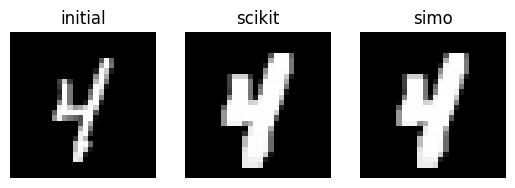

In [54]:
fig, axs = plt.subplots(ncols=3, nrows=1)

axs[0].set_title('initial')
axs[0].axis('off')
axs[0].imshow(before, cmap='gray')

axs[1].set_title('scikit')
axs[1].axis('off')
axs[1].imshow(im_scikit, cmap='gray')

axs[2].set_title('simo')
axs[2].axis('off')
axs[2].imshow(im_simo, cmap='gray')

plt.show();

In [55]:
# Single image (square matrix)
for im in batch:
    im_scikit = binary_dilation(im, footprint)
    im_simo = dilate_binary(im, footprint)
    print(np.all(im_scikit == im_simo))

# Multiple images (non-square matrix)
tmp_batch = np.hstack(batch)
im_scikit = binary_dilation(tmp_batch, footprint)
im_simo = dilate_binary(tmp_batch, footprint)
print(np.all(im_scikit == im_simo))

# Save to files to inspect
concatted = np.concatenate([tmp_batch, im_scikit, im_simo], axis=1).astype(np.uint8)
np.savetxt("array.txt", concatted, fmt='%d', delimiter='')

True
True
True
True
True
True
True
True
True
True
True


# Erosion

In [56]:
def erode_binary(im, footprint):
    if footprint.shape[0] != footprint.shape[1] or footprint[footprint.shape[0] // 2, footprint.shape[1] // 2] != 1:
        raise ValueError('Footprint must be a square with 1 in its center!')

    im = im.astype(np.uint8)

    result = np.zeros_like(im, dtype=np.uint8)

    cols = im.shape[1]

    one_idx = [(i // cols, i % cols) for (i, val) in enumerate(im.flatten()) if val == 1]

    for (i, j) in one_idx:
        ii = i - 1
        jj = j - 1

        i_norm = (ii if ii > 0 else 0)
        j_norm = (jj if jj > 0 else 0)
        
        part = im[i_norm:ii+3, j_norm:jj+3]

        offset_i = i_norm - ii
        offset_j = j_norm - jj
        mask = footprint[offset_i : offset_i + part.shape[0], offset_j : part.shape[1]]

        if np.all(part == mask):
            result[i, j] = 1

    return result

In [57]:
def erode(im, footprint):
    if footprint.shape[0] != footprint.shape[1] or footprint[footprint.shape[0] // 2, footprint.shape[1] // 2] != 1:
        raise ValueError('Footprint must be a square with 1 in its center!')

    im = im.astype(np.uint8)
    result = np.zeros_like(im, dtype=np.uint8)

    rows = im.shape[0]
    cols = im.shape[1]

    for i in range(rows):
        for j in range(cols):
            ii = i - 1
            jj = j - 1

            i_norm = (ii if ii > 0 else 0)
            j_norm = (jj if jj > 0 else 0)
            
            part = im[i_norm:ii+3, j_norm:jj+3]
            result[i, j] = np.min(part)

    return result

## Compare with `scikit-image`

In [58]:
footprint = np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1]], dtype = np.uint8)

before.astype(np.uint8)
im_scikit = erosion(before, footprint).astype(np.uint8)
im_simo = erode(before, footprint).astype(np.uint8)
np.all(im_scikit == im_simo)

True

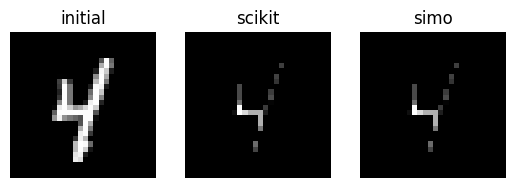

In [59]:
fig, axs = plt.subplots(ncols=3, nrows=1)

axs[0].set_title('initial')
axs[0].axis('off')
axs[0].imshow(before, cmap='gray')

axs[1].set_title('scikit')
axs[1].axis('off')
axs[1].imshow(im_scikit, cmap='gray')

axs[2].set_title('simo')
axs[2].axis('off')
axs[2].imshow(im_simo, cmap='gray')

plt.show();

In [60]:
# Single image (square matrix)
for im in batch:
    im_scikit = binary_erosion(im, footprint)
    im_simo = erode_binary(im, footprint)
    print(np.all(im_scikit == im_simo))

# Multiple images (non-square matrix)
tmp_batch = np.hstack(batch)
im_scikit = binary_erosion(tmp_batch, footprint)
im_simo = erode_binary(tmp_batch, footprint)
print(np.all(im_scikit == im_simo))

# Save to files to inspect
concatted = np.concatenate([tmp_batch, im_scikit, im_simo], axis=1).astype(np.uint8)
np.savetxt("array.txt", concatted, fmt='%d', delimiter='')

True
True
True
True
True
True
True
True
True
True
True


# Geodesic Dilation

In [61]:
def geodesic_dilation(mask, marker):
    footprint = np.array([[1, 1, 1],
                          [1, 1, 1],
                          [1, 1, 1]], dtype = np.uint8)

    result = dilate(marker, footprint).astype(bool) & mask
    return result

# Geodesic Erosion

In [62]:
def geodesic_erosion(mask, marker):
    footprint = np.array([[1, 1, 1],
                          [1, 1, 1],
                          [1, 1, 1]], dtype = np.uint8)

    result = erode(marker, footprint) | mask
    return result

# Morphological Reconstruction

In [63]:
mask = np.array([
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,1,1,1,0,0,0,0],
    [0,0,0,1,0,1,0,0,0,0],
    [0,0,0,1,1,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
])
marker = np.array([
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
])

In [64]:
def morphological_reconstruction_dilation(mask, marker):
    step0 = marker.copy()

    while True:
        step1 = geodesic_dilation(mask, step0)
        step2 = geodesic_dilation(mask, step1)

        if np.all(step1 == step2):
            break

        step0 = step2

    return step1

In [65]:
morphological_reconstruction_dilation(mask, marker)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# Test on grayscale image

(571, 567)
[ 31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  86  87
  88  89  90  91  92  93  95  96  97  98  99 100 101 102 103 104 106 108
 109 110 111 112 113 114 115 116 117 118 120 122 123 124 125 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 186 187 188 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 209 212 216 218 221 255]


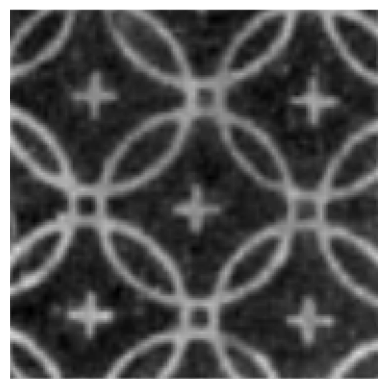

In [78]:
import imageio as iio

im = iio.v3.imread('./assets/grayscale_pluses.png')
im = 0.07 * im[:,:,2] + 0.72 * im[:,:,1] + 0.21 * im[:,:,0]
im = im.astype(np.uint8)

print(im.shape)
print(np.unique(im))

plt.axis('off')
plt.imshow(im, cmap='gray');

In [67]:
im_scikit = dilation(im, footprint)
im_simo = dilate(im, footprint)
np.all(im_scikit == im_simo)

True

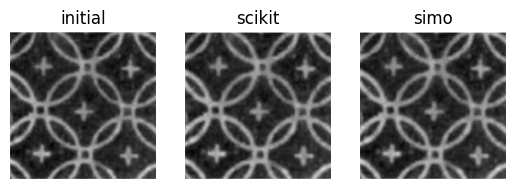

In [68]:
fig, axs = plt.subplots(ncols=3, nrows=1)

axs[0].set_title('initial')
axs[0].axis('off')
axs[0].imshow(im, cmap='gray')

axs[1].set_title('scikit')
axs[1].axis('off')
axs[1].imshow(im_scikit, cmap='gray')

axs[2].set_title('simo')
axs[2].axis('off')
axs[2].imshow(im_simo, cmap='gray')

plt.show();

# Application 1: Remove objects specified by user

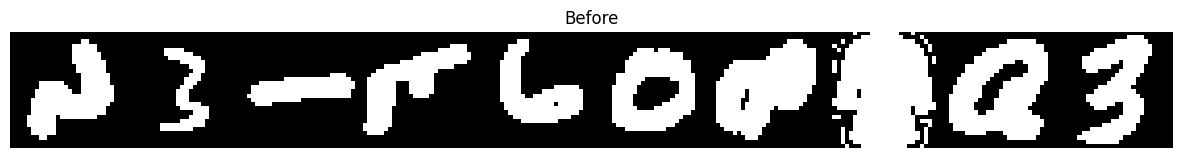

In [69]:
mask = np.hstack(batch).astype(np.uint8)
print_batch(mask, 'Before')

In [70]:
marker = np.zeros_like(mask)
marker[23, 37] = 1
marker[3, 242] = 1

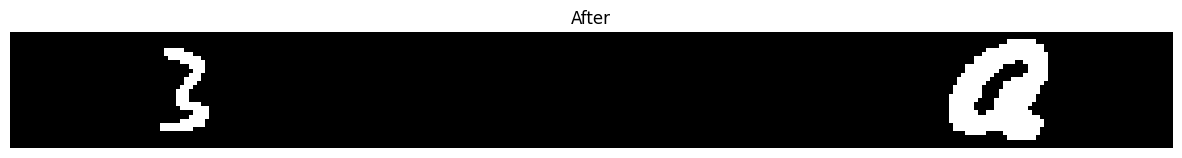

In [71]:
res = morphological_reconstruction_dilation(mask, marker)
print_batch(res, 'After')

# Application 2: Remove objects connected to border

- mask = input image
- marker = intersection between the input image and its border

The marker image contains therefore seeds for each particle connected to the image border and the reconstruction outputs the image of all these particles.

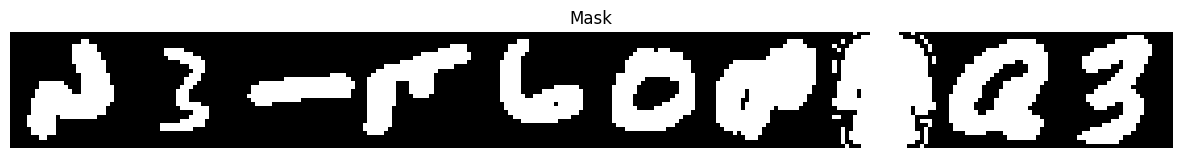

In [72]:
print_batch(mask, 'Mask')

In [73]:
marker = np.ones_like(mask)
marker[1:marker.shape[0] - 1, 1:marker.shape[1] - 1] = 0
marker = marker & mask

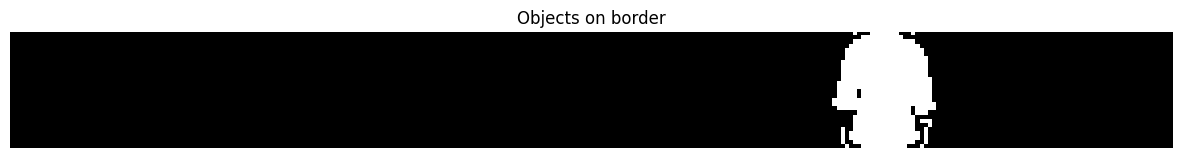

In [74]:
res = morphological_reconstruction_dilation(mask, marker)
print_batch(res, 'Objects on border')

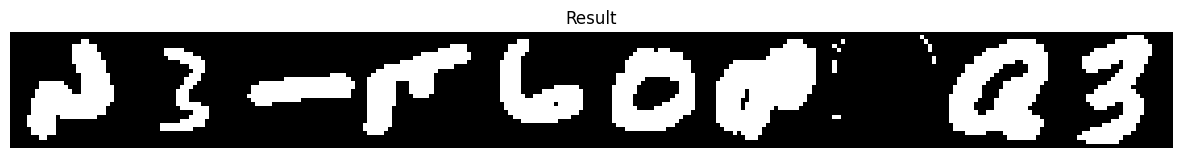

In [75]:
res = mask - res
print_batch(res, 'Result')